In [1]:
import zipfile
import pandas as pd
from pandas_profiling import ProfileReport
import random

#zf = zipfile.ZipFile("https://github.com/alexmjn/Predicting-Arrests/blob/master/offenses-standardized.csv.zip")
#crime = pd.read_csv(zf.open("offenses.standardized.csv"))

import category_encoders as ce
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import eli5
from eli5.sklearn import PermutationImportance

from pandas_profiling import ProfileReport
from scipy.stats import uniform, randint

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

from IPython.display import display

C:\Users\ajenk\Anaconda3\envs\unit2\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\ajenk\Anaconda3\envs\unit2\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
 #crime = pd.read_csv("C:/Users/ajenk/GitHub/Crime_Data/offenses-standardized.csv")

In [3]:
# might want to explicitly set dtypes

In [4]:
#crime.dtypes

In [5]:
#crime.shape

In [6]:
#profile = ProfileReport(crime, minimal=True).to_notebook_iframe()
#profile

In [21]:
filename = "C:/Users/ajenk/GitHub/Crime_Data/offenses-standardized.csv"
random.seed(42)
p = .2
fields = ["agency_name", "occurred_date", 
          "occurred_time", "firearm_ind", "offense_group", "domestic_violence_ind", "victim_age",
          "victim_race", "victim_ethnicity", "victim_race_condensed", "victim_sex", "clearance_group"]

crime = pd.read_csv(filename, usecols = fields, skiprows = lambda i: i > 0 and random.random() > p)

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
train, test = train_test_split(crime, test_size = .2, random_state = 42)

In [24]:
train.describe(include = "all")

,agency_name,occurred_date,occurred_time,firearm_ind,offense_group,domestic_violence_ind,victim_age,victim_race,victim_ethnicity,victim_race_condensed,victim_sex,clearance_group
count,119476,119464,116547,119476,119476,75120,44264,45842,32065,119476,45829,119476
unique,22,8302,1440,6,7,5,198,46,22,3,14,5
top,CHICAGO-PD,2011-01-01,00:00,N,Agg Assault - Other Weapon,N,21,BLACK,N,OTHER/UNKNOWN,M,Open & No Arrest-Unspecified
freq,44563,51,3862,69062,67908,59125,1123,13817,8256,76218,20992,71197


In [11]:
profile = ProfileReport(crime, minimal=True).to_notebook_iframe()
profile

In [11]:
train["clearance_group"].value_counts()

Open & No Arrest-Unspecified           71197
Cleared-Arrest & Arrest-Unspecified    37016
Cleared/Closed-Unspecified              6241
Cleared-Ex                              4990
Null, Missing, Unclear                    32
Name: clearance_group, dtype: int64

I think "Arrest Made" is going to be the variable of interest here. Less missing data in clearance_group, so I can cast this into a binary: "cleared" or "open & no arrest." I want to learn more about "Cleared/Closed - Unspecified" as well.

In [25]:
def extract_time_and_date(df):
    df["occurred_date"] = pd.to_datetime(df["occurred_date"], infer_datetime_format=True)
    df["occurred_time"] = pd.to_datetime(df["occurred_time"], infer_datetime_format=True)
    
    df["hour"] = df["occurred_time"].dt.hour
    df["hour_zero"] = df["occurred_time"] == pd.to_datetime("00:00")
    df["year"] = df["occurred_date"].dt.year
    df["month"] = df["occurred_date"].dt.month
    
    df = df.drop(["occurred_date", "occurred_time"], axis = 1)
    return df

def clean_age_category(df):
    df["victim_age"] = df["victim_age"].replace({"UNDER 18": "17"})
    df["victim_age"] = df["victim_age"].astype("float")
    
    #df["victim_age_group"] = pd.cut(df["victim_age"], range(0, 100, 6))
    #df = df.drop(["victim_age"], axis = 1)
    #this code returns a series of ranges which sklearn doesn't like; forest models 
    #should be able to turn numerical data into "categories" anyways
    return df

#move outside wrangle; create target and baselines before any wrangling/engineering
def create_binary_target(df):
    df["cleared"] = ~(df["clearance_group"] == "Open & No Arrest-Unspecified")
    df = df.drop(["clearance_group"], axis = 1)
    return df

In [26]:
def wrangle(df):
    df = df.copy()
    df = extract_time_and_date(df)
    df = clean_age_category(df)
    df = create_binary_target(df)
    
    return df

In [27]:
train = wrangle(train)
train.shape

(119476, 14)

In [28]:
test = wrangle(test)
test.shape

(29870, 14)

In [29]:
train["cleared"].value_counts(normalize = True)

#fast first model - logistic regression - second baseline
# move as early as possible in data exploration

False    0.59591
True     0.40409
Name: cleared, dtype: float64

In [30]:
train.columns

Index(['agency_name', 'firearm_ind', 'offense_group', 'domestic_violence_ind',
       'victim_age', 'victim_race', 'victim_ethnicity',
       'victim_race_condensed', 'victim_sex', 'hour', 'hour_zero', 'year',
       'month', 'cleared'],
      dtype='object')

In [31]:
target = "cleared"
features = train.drop([target], axis = 1).columns.to_list()

In [32]:
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [33]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

#looks like 40 depth, 4 samples per leaf, estimators 700-1200, agnostic mean/median.
# try flagging missing data.
# try flagging missing data. get feat importances. check on redundant areas.
# for imputation check what's missing and present per agency.

((119476, 13), (119476,), (29870, 13), (29870,))

In [22]:
def generate_most_common(feature):
    train_plot = train.copy()
    top_obs = train_plot[feature].value_counts()[:8].index
    train_plot.loc[~train_plot[feature].isin(top_obs), feature] = "other"
    
    return train_plot

def graph_feature(feature):
    train_plot = generate_most_common(feature = feature)
    
    fig, ax = plt.subplots(figsize = (25, 10))

    sns.countplot(x = train_plot[feature], hue = train_plot[target])
    ax.tick_params(axis = 'both', labelsize = 16)
    plt.show()

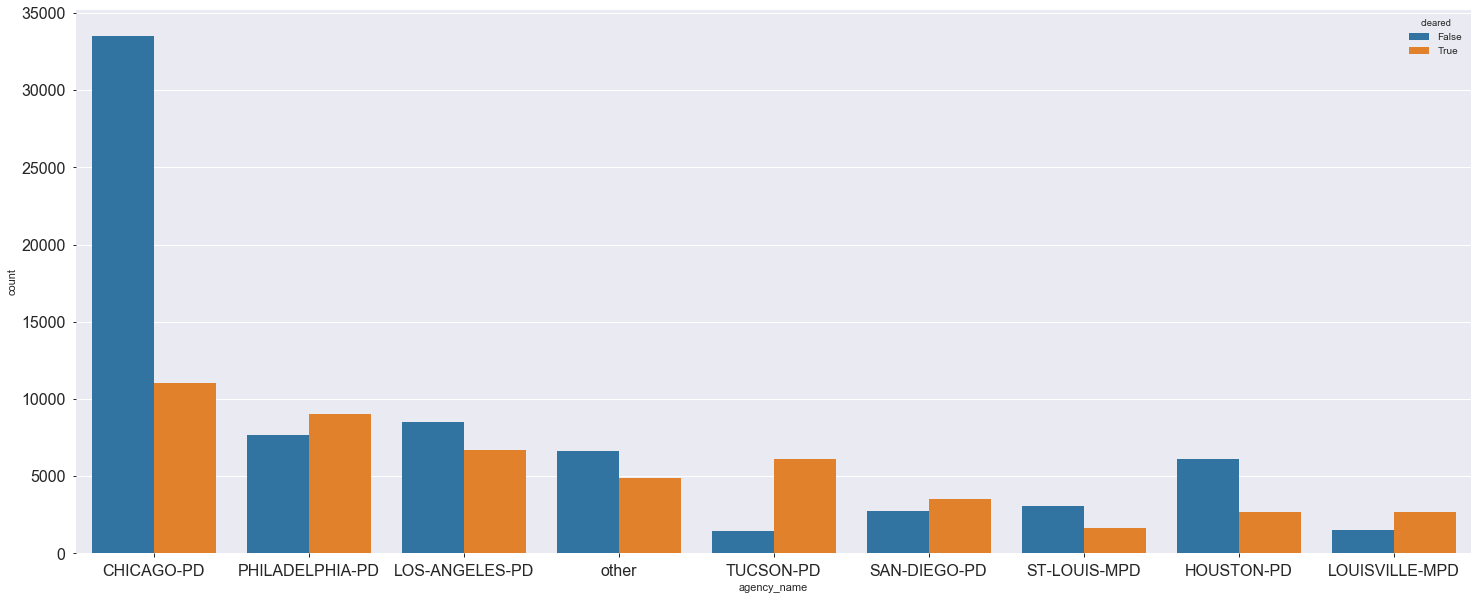

In [23]:
graph_feature("agency_name")

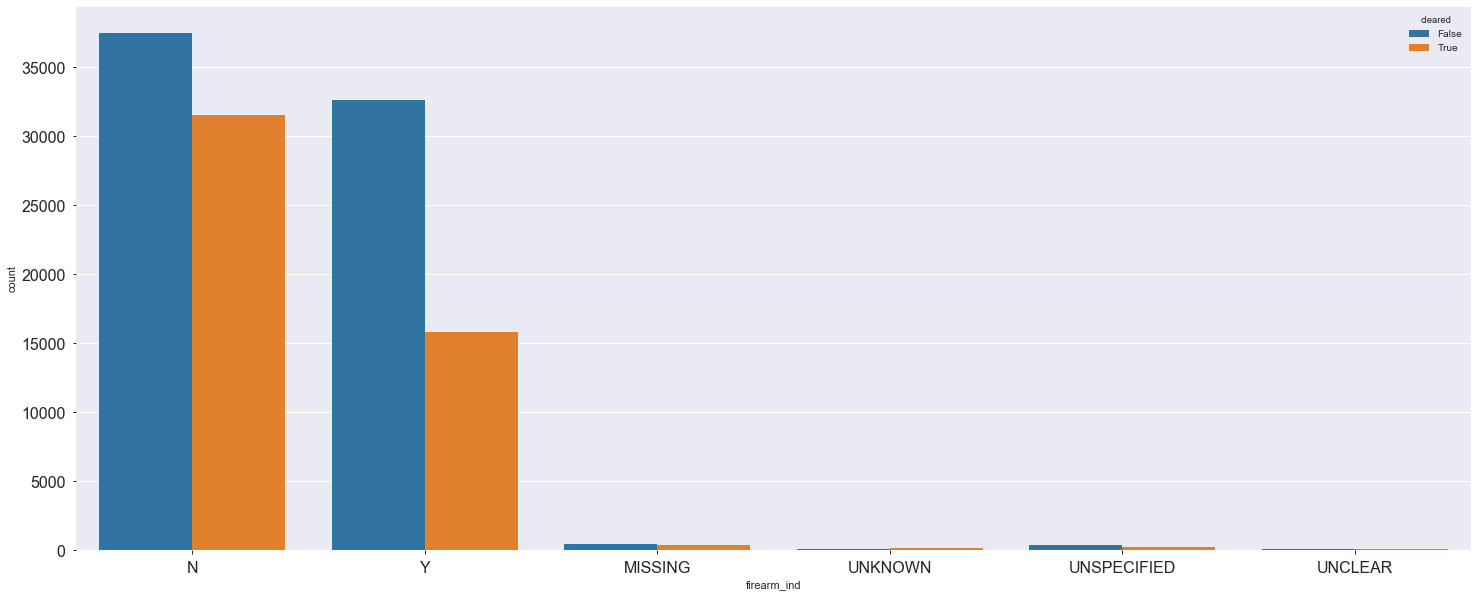

In [24]:
graph_feature("firearm_ind")

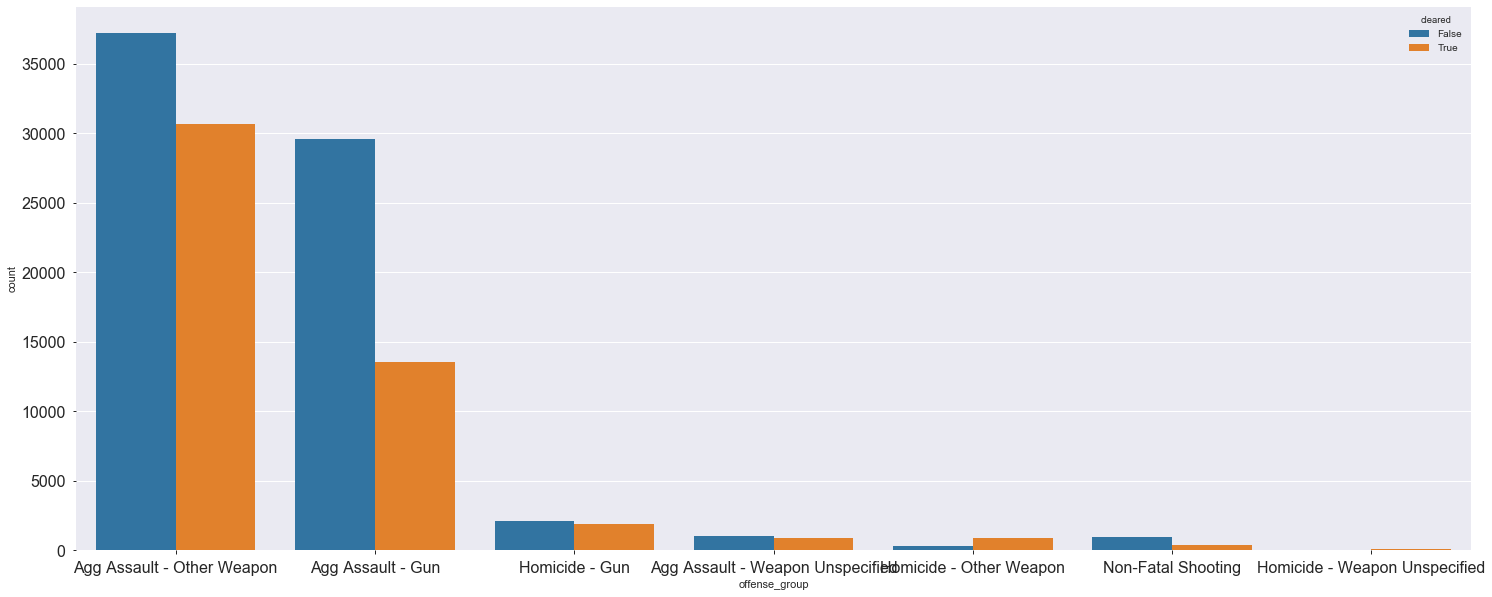

In [25]:
graph_feature("offense_group")

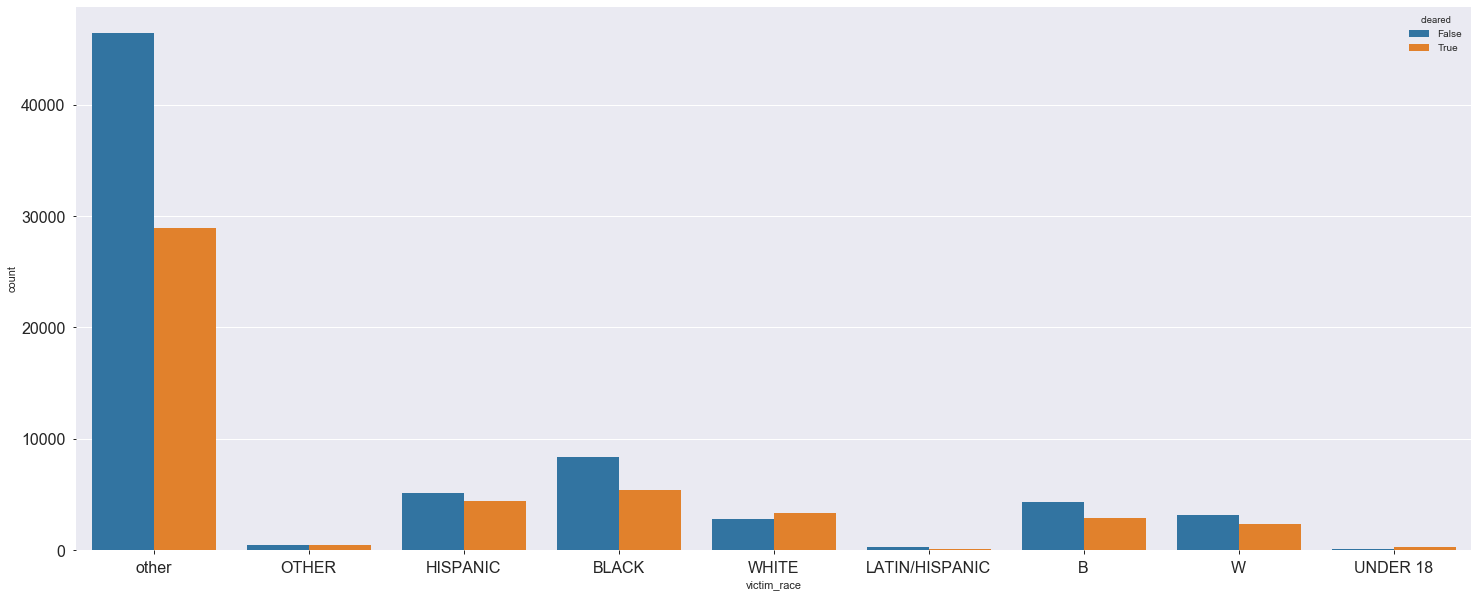

In [26]:
graph_feature("victim_race")

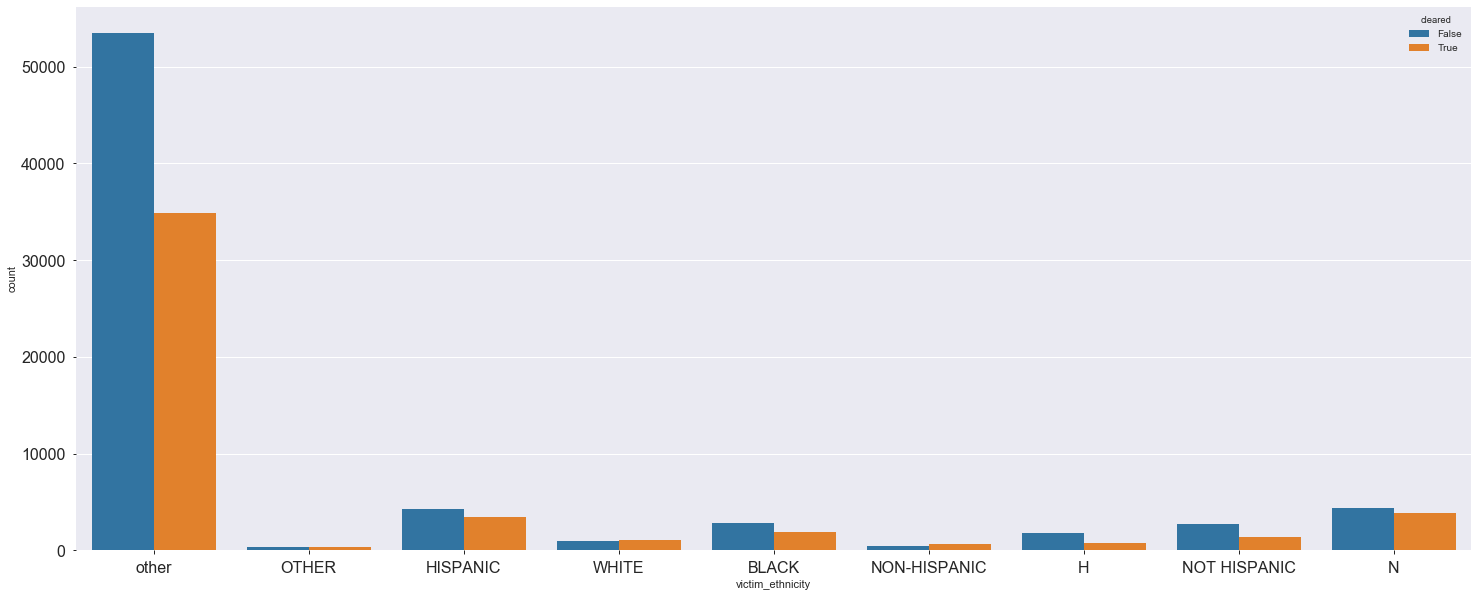

In [27]:
graph_feature("victim_ethnicity")

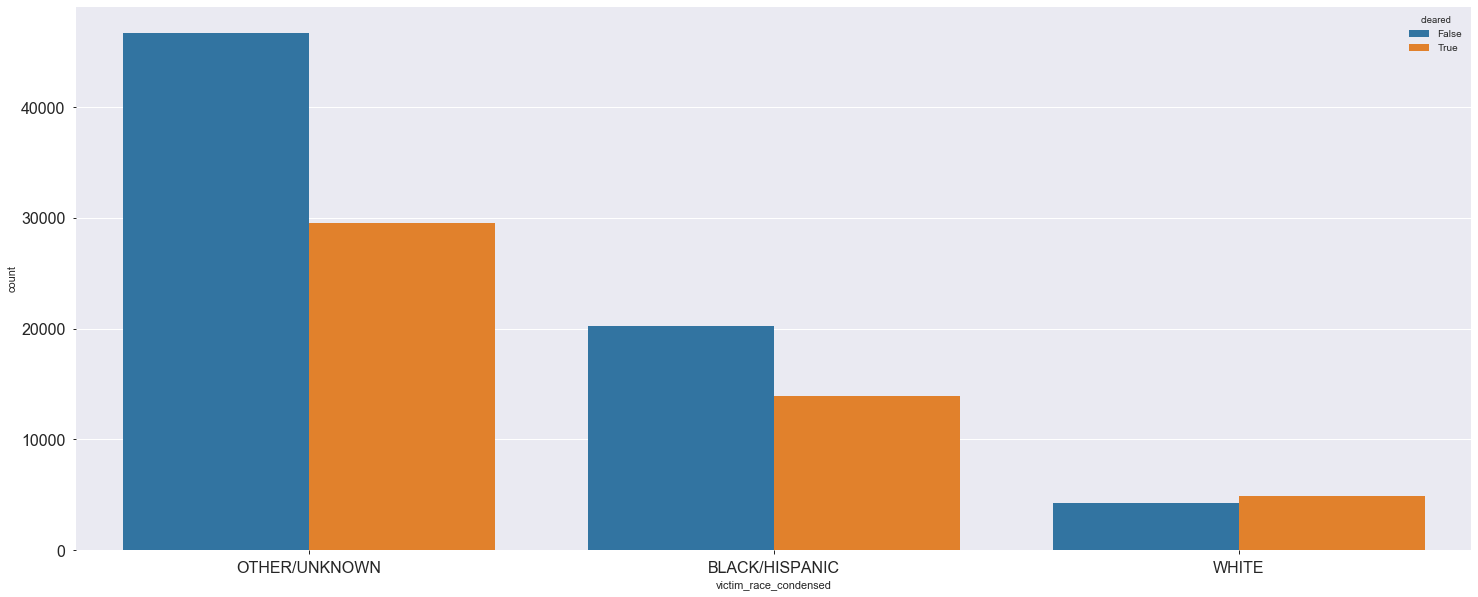

In [28]:
graph_feature("victim_race_condensed")

In [20]:
X_train.columns

Index(['agency_name', 'firearm_ind', 'offense_group', 'domestic_violence_ind',
       'victim_age', 'victim_race', 'victim_ethnicity',
       'victim_race_condensed', 'victim_sex', 'clearance_group', 'hour',
       'hour_zero', 'year', 'month'],
      dtype='object')

In [34]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    #handle on a feature's null values feature by feature
    RandomForestClassifier(random_state = 42)
)

param_distributions = {
    'simpleimputer__strategy' : ['mean', 'median'],
    'randomforestclassifier__n_estimators': randint(100, 1500),
    'randomforestclassifier__max_depth': [5, 15, 25, 40, 50],
    'randomforestclassifier__min_samples_leaf': randint(1, 5)
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions = param_distributions,
    n_iter = 7,
    cv = 5,
    scoring = 'accuracy',
    verbose = 10,
    return_train_score = True,
    n_jobs = -1
    )

search.fit(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 18.0min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 20.3min
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed: 26.2min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed: 28.1min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,


In [35]:
print(search.best_params_)
print(search.best_score_)
pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score').T

{'randomforestclassifier__max_depth': 15, 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__n_estimators': 950, 'simpleimputer__strategy': 'mean'}
0.7031202515777198


,6,1,0,5,4,2,3
mean_fit_time,98.1886,139.939,137.509,131.729,54.1329,124.856,187.924
std_fit_time,7.43637,22.0017,2.40338,4.59108,0.609683,15.954,9.72007
mean_score_time,6.69329,10.3923,22.7825,21.4079,2.58521,19.2181,43.8185
std_score_time,1.80318,0.704742,5.47047,4.18432,0.0937726,3.54889,12.4042
param_randomforestclassifier__max_depth,15,15,40,50,5,40,50
param_randomforestclassifier__min_samples_leaf,4,4,3,2,1,2,1
param_randomforestclassifier__n_estimators,950,1254,1116,1026,1199,817,1092
param_simpleimputer__strategy,mean,mean,mean,median,mean,mean,mean
params,"{'randomforestclassifier__max_depth': 15, 'ran...","{'randomforestclassifier__max_depth': 15, 'ran...","{'randomforestclassifier__max_depth': 40, 'ran...","{'randomforestclassifier__max_depth': 50, 'ran...","{'randomforestclassifier__max_depth': 5, 'rand...","{'randomforestclassifier__max_depth': 40, 'ran...","{'randomforestclassifier__max_depth': 50, 'ran..."
split0_test_score,0.707943,0.707901,0.6961,0.688483,0.688735,0.68886,0.666681


My first model - with a max depth of 25, 4 features per leaf, an imputer strategy of "Median" (no flags), and 328 estimators got a score of .690. This comfortably beats the baseline. Because of a prior hyperparam search that stopped early, I know this isn't even the best model -- 40/4/X/1000 got around .698 -- but this is suitable for me to plot feature importances and start to look at feature engineering, further data cleanup, etc.

I fit a pipeline with the parameters found through param search then plot feature importances.

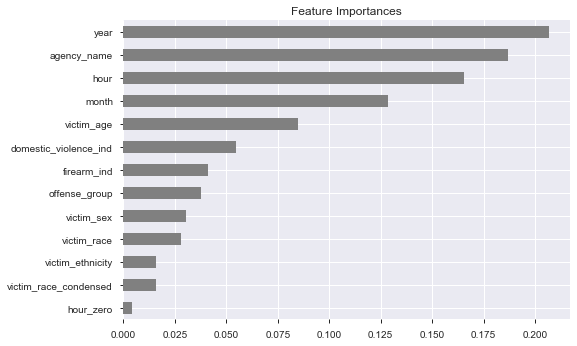

In [36]:
# get feature importances from named steps
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy = "mean"),
    RandomForestClassifier(max_depth = 25, n_estimators = 800, min_samples_leaf = 4, random_state = 42)
    )

pipeline.fit(X_train, y_train)

rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)
plt.figure()
plt.title("Feature Importances")
importances.sort_values().plot.barh(color='grey');


Awkwardly, row_hash, which is a unique identifier I didn't drop from the data, comes out as the most important feature. This shows the flexibility of random forests, I suppose, but certainly this is not something that I can expect to generalize. 

The agency, unsurprisingly, shows up as very important. The year shows up as very important as well; secular trends might be involved here.

All of these variables would be nice plotted against my target variable for EDA. Perhaps this could even be functionalized. 

Next I get the permutation importances for this same model. For my models where I'm not cross-validating, I pull a validation set.

In [37]:
train, val = train_test_split(train, test_size = .2, random_state = 42)
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

In [38]:
transformers = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer()
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model2 = RandomForestClassifier(n_estimators = 1000, random_state = 42, 
                                min_samples_leaf = 4, n_jobs = -1)
model2.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [39]:
model2.score(X_val_transformed, y_val)

0.6954720455306327

In [40]:
permuter = PermutationImportance(
    model2,
    scoring = 'accuracy',
    n_iter = 5,
    random_state = 42
)

permuter.fit(X_val_transformed, y_val)
feature_names = X_val.columns.tolist()
eli5.show_weights(
    permuter,
    top = None,
    feature_names = feature_names
)

# if included in notebook - include it in your story - make sure you actually use it to refine your model

Weight,Feature
0.0887 ± 0.0040,agency_name
0.0473 ± 0.0029,domestic_violence_ind
0.0440 ± 0.0042,firearm_ind
0.0275 ± 0.0027,year
0.0064 ± 0.0021,offense_group
0.0045 ± 0.0009,hour
0.0039 ± 0.0022,victim_sex
0.0023 ± 0.0014,victim_race
0.0020 ± 0.0004,victim_age
0.0018 ± 0.0016,month


In [41]:
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

model3 = XGBClassifier(
    n_estimators = 1000,
    max_depth = 7,
    learning_rate = .3,
    n_jobs = -1,
)

eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]

model3.fit(X_train_encoded,
          y_train,
          eval_set = eval_set,
          eval_metric = 'error',
          early_stopping_rounds = 50
          )

[0]	validation_0-error:0.307094	validation_1-error:0.309131
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.302856	validation_1-error:0.306955
[2]	validation_0-error:0.301684	validation_1-error:0.305156
[3]	validation_0-error:0.298943	validation_1-error:0.30457
[4]	validation_0-error:0.297719	validation_1-error:0.301347
[5]	validation_0-error:0.297018	validation_1-error:0.300762
[6]	validation_0-error:0.295229	validation_1-error:0.302477
[7]	validation_0-error:0.294005	validation_1-error:0.300218
[8]	validation_0-error:0.293158	validation_1-error:0.299841
[9]	validation_0-error:0.291913	validation_1-error:0.300218
[10]	validation_0-error:0.291128	validation_1-error:0.299925
[11]	validation_0-error:0.290448	validation_1-error:0.300092
[12]	validation_0-error:0.290134	validation_1-error:0.300092
[13]	validation_0-error:0.288523	validation_1-error:0.300

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [42]:
model3.score(X_val_encoded, y_val)

0.7020003347840643

In [43]:
model3.feature_importances_

array([0.22331394, 0.19537264, 0.0388063 , 0.30535194, 0.01803263,
       0.02526967, 0.02272097, 0.02500053, 0.03201111, 0.01956413,
       0.04062094, 0.03780063, 0.01613452], dtype=float32)

In [44]:
model3.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)>

In [45]:
permuter = PermutationImportance(
    model3,
    scoring = 'accuracy',
    n_iter = 5,
    random_state = 42
)

permuter.fit(X_val_transformed, y_val)
feature_names = X_val.columns.tolist()
eli5.show_weights(
    permuter,
    top = None,
    feature_names = feature_names
)

ValueError: feature_names mismatch: ['agency_name', 'firearm_ind', 'offense_group', 'domestic_violence_ind', 'victim_age', 'victim_race', 'victim_ethnicity', 'victim_race_condensed', 'victim_sex', 'hour', 'hour_zero', 'year', 'month'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12']
expected month, victim_age, victim_race, victim_sex, firearm_ind, offense_group, hour, hour_zero, victim_race_condensed, agency_name, year, victim_ethnicity, domestic_violence_ind in input data
training data did not have the following fields: f1, f10, f0, f4, f5, f12, f2, f7, f3, f9, f11, f8, f6